In [1]:
import numpy as np
import os
import tensorflow as tf
import cv2
from skimage.transform import resize
from skimage.io import imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches

category_names = ['Bier', 'Bier Maß', 'Weißbier', 'Cola', 'Wasser', 'Curry-Wurst', 'Weißwein',
                   'A-Schorle', 'Jägermeister', 'Pommes', 'Burger', 'Williamsbirne', 'Alm-Breze', 'Brotzeitkorb',
                   'Käsespätzle']

In [2]:
class Predictor:
    """
    This class loads and runs the tensorflow model
    """
    def __init__(self, frozen_graph, image_size=(300, 300), gpu=None):
        """
        frozen_graph: the path to the model
        gpu: which gpu to use
        """
        self.image_size = image_size
        # load model into detection_graph
        if gpu is not None:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
        detection_graph = tf.Graph()
        with detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(frozen_graph, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
        self.graph = detection_graph
        with self.graph.as_default():
            self.sess = tf.Session()
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            self.tensor_dict = {}
            for key in ['detection_scores', 'detection_classes', 'detection_boxes']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    self.tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            self.image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

    def predict(self, image):
        """
        image: one image (that has the correct aspect ratio, usually 1:1)
        returns: the predicted bounding boxes, classes, and confidence scores as a dict
        """
        if image.shape[0] != self.image_size[0] or image.shape[1] != self.image_size[1]:
            image = (resize(image, self.image_size) * 255).astype(np.uint8)
        
        with self.graph.as_default():
            output_dict = self.sess.run(self.tensor_dict, feed_dict={self.image_tensor: image[np.newaxis]})
            for k in output_dict.keys():
                output_dict[k] = output_dict[k][0]
            output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int32) - 1
            return output_dict

In [3]:
# this function plots the image
def plot(img, out_dict, thresh):
    """
    img: an image
    out_dict: the detections of Predictor::predict
    thresh: the threshold for filtering out predicitons below a certain threshold
    """
    bxs = out_dict['detection_boxes']
    clss = out_dict['detection_classes']
    scr = out_dict['detection_scores']
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img / 255)
    for j in range(len(bxs)):
        if scr[j] < thresh:
            continue
        bx, by = bxs[j, 1] * img.shape[0], bxs[j, 0] * img.shape[1]
        bw, bh = (bxs[j, 3] - bxs[j, 1]) * img.shape[0], (bxs[j, 2] - bxs[j, 0]) * img.shape[1]
        rect = patches.Rectangle((bx, by), bw, bh,linewidth=2, edgecolor='g',facecolor='none')
        ax.add_patch(rect)
        plt.text(bx, by, '%s: %.0f%%' % (category_names[int(clss[j])], scr[j]*100))

In [4]:
path_to_model = '/nfs/students/winter-term-2018/project_2/final_files/models/ssd_fpn.pb'
p = Predictor(path_to_model, (640, 640))

In [5]:
img1 = imread(os.path.join('images', 'example1.jpg'))

# reshape to aspect ratio of 1:1
img1 = img1[:, 175:1225]

/nfs/homedirs/hansjako/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/nfs/homedirs/hansjako/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


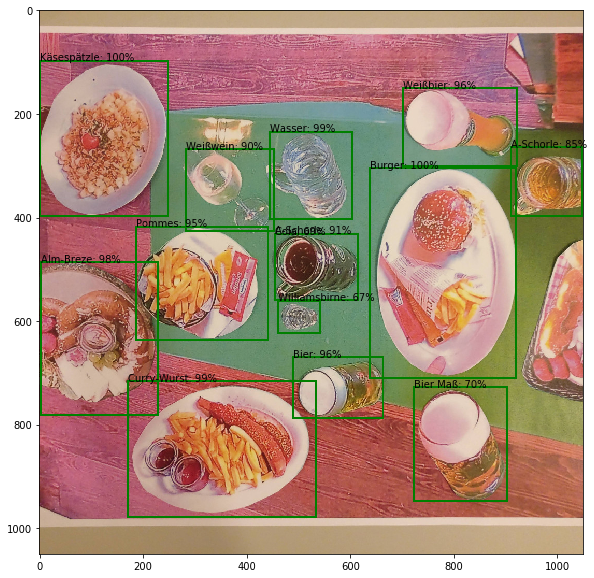

In [6]:
plot(img1, p.predict(img1), .6)